In [64]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import folium
from folium import GeoJson

In [74]:
# 加载 GeoJSON 或 Shapefile 数据
historical_beds = gpd.read_file("/Users/lijinpeng/Desktop/MDoyster/data/Restoration/Yates_Oyster_Bars.geojson")
restoration_areas = gpd.read_file("/Users/lijinpeng/Desktop/MDoyster/data/Restoration/Maryland_Shellfish_-_Historic_Oyster_Plantings.geojson")
sanctuaries_areas = gpd.read_file("/Users/lijinpeng/Desktop/MDoyster/data/Restoration/Maryland_Shellfish_-_Oyster_Sanctuaries.geojson")

In [12]:
print(restoration_areas.info())

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 6282 entries, 0 to 6281
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   OBJECTID      6282 non-null   int32              
 1   ActivityYr    6282 non-null   object             
 2   ActType       6282 non-null   object             
 3   StartDate     1777 non-null   datetime64[ms, UTC]
 4   EndDate       492 non-null    datetime64[ms, UTC]
 5   AcresPlant    6282 non-null   float64            
 6   VolMill       6282 non-null   float64            
 7   VolBu         6282 non-null   float64            
 8   BarnamePh     6282 non-null   object             
 9   NearBar       6282 non-null   object             
 10  RegionPhy     6282 non-null   object             
 11  County        6282 non-null   object             
 12  CentroidX     6282 non-null   float64            
 13  CentroidY     6282 non-null   float64            
 14  

In [10]:
print(restoration_areas.head())

   OBJECTID ActivityYr                 ActType                 StartDate  \
0         1       2017  HATCHERY SEED PLANTING 2017-04-05 00:00:00+00:00   
1         2       2017  HATCHERY SEED PLANTING 2017-06-06 00:00:00+00:00   
2         3       2017  HATCHERY SEED PLANTING 2017-04-27 00:00:00+00:00   
3         4       2017  HATCHERY SEED PLANTING 2017-08-08 00:00:00+00:00   
4         5       2017  HATCHERY SEED PLANTING 2017-04-10 00:00:00+00:00   

                    EndDate  AcresPlant  VolMill  VolBu           BarnamePh  \
0                       NaT    2.610244    11.78    0.0       TOBACCO STICK   
1 2017-06-14 00:00:00+00:00    4.109568    18.69    0.0                       
2 2017-05-02 00:00:00+00:00   10.176783    42.32    0.0          LOUIS COVE   
3                       NaT    0.858179     4.07    0.0         PECKS POINT   
4                       NaT    2.197289    15.72    0.0  BAMINGS COVE ADD 1   

       NearBar  ... County  CentroidX  CentroidY  Sanctuary  \
0    

In [3]:
# 确保两者使用相同的坐标系
historical_beds = historical_beds.to_crs(epsg=4326)
restoration_areas = restoration_areas.to_crs(epsg=4326)


In [32]:
# 将 ActivityYr 转换为数字类型
restoration_areas['ActivityYr'] = pd.to_numeric(restoration_areas['ActivityYr'], errors='coerce')

## Explore planting dataset

In [48]:
# 过滤掉 ActivityYr 为 NA 的记录
restoration_areas = restoration_areas.dropna(subset=['ActivityYr'])

# 过滤掉 ActType 为 UNKNOWN 的记录
restoration_areas = restoration_areas[restoration_areas['ActType'] != 'UNKNOWN']

# 替换 ActType 中的 'HATCHERY SEED PLANTINGS' 为 'HATCHERY SEED PLANTING'
restoration_areas['ActType'] = restoration_areas['ActType'].replace(
    {'HATCHERY SEED PLANTINGS': 'HATCHERY SEED PLANTING'}
)


In [49]:
# 查看 ActType 的唯一值
unique_act_types = restoration_areas['ActType'].unique()
print(f"ActType 有以下种类: {unique_act_types}")


ActType 有以下种类: ['HATCHERY SEED PLANTING' 'ALTERNATE MATERIALS' 'DREDGED SHELL ADDITION'
 'FRESH SHELL PLANTING' 'WILD SEED PLANTING' 'MIXED SHELL'
 'BAR ENHANCEMENT' 'AQUA OYS PLANTING' 'DIRECT SET OYSTER LARVAE'
 'MIXED SHELL PLANTING']


In [50]:
# 计算每种 ActType 和年份的面积
restoration_areas['area'] = restoration_areas.geometry.area  # 确保计算面积

# 按 ActType 和 ActivityYr 分组求面积总和
acttype_area_by_year = restoration_areas.groupby(['ActType', 'ActivityYr'])['area'].sum().reset_index()

# 查看前几行结果
print(acttype_area_by_year.head())

               ActType  ActivityYr          area
0  ALTERNATE MATERIALS      1953.0  2.230703e-05
1  ALTERNATE MATERIALS      2001.0  5.008016e-07
2  ALTERNATE MATERIALS      2002.0  1.830280e-05
3  ALTERNATE MATERIALS      2003.0  4.758227e-06
4  ALTERNATE MATERIALS      2004.0  7.138611e-08


/var/folders/sd/bq10trhj0z7_p4t5bg48p4780000gn/T/ipykernel_59171/1992770729.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  restoration_areas['area'] = restoration_areas.geometry.area  # 确保计算面积


In [51]:
# 添加一个新列，标记是 2010 之前还是 2010 及之后
restoration_areas['time_period'] = restoration_areas['ActivityYr'].apply(
    lambda x: 'Before 2010' if x < 2010 else '2010 and After'
)

# 按 time_period 分组计算总面积
area_by_time_period = restoration_areas.groupby('time_period')['area'].sum().reset_index()

# 查看结果
print(area_by_time_period)


      time_period      area
0  2010 and After  0.003214
1     Before 2010  0.038239


In [53]:
# 按 ActType 和 time_period 分组计算面积总和
area_by_type_and_time = restoration_areas.groupby(['ActType', 'time_period'])['area'].sum().reset_index()

# 对每个时间段分别排序并提取前三名
top3_types_by_period = area_by_type_and_time.groupby('time_period').apply(
    lambda x: x.nlargest(3, 'area')
).reset_index(drop=True)

# 查看结果
print(top3_types_by_period)



                  ActType     time_period      area
0  HATCHERY SEED PLANTING  2010 and After  0.001777
1    FRESH SHELL PLANTING  2010 and After  0.000692
2  DREDGED SHELL ADDITION  2010 and After  0.000352
3      WILD SEED PLANTING     Before 2010  0.022854
4  DREDGED SHELL ADDITION     Before 2010  0.012942
5    FRESH SHELL PLANTING     Before 2010  0.001448


/var/folders/sd/bq10trhj0z7_p4t5bg48p4780000gn/T/ipykernel_59171/1542598286.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top3_types_by_period = area_by_type_and_time.groupby('time_period').apply(


## 分析位置上的变化

/var/folders/sd/bq10trhj0z7_p4t5bg48p4780000gn/T/ipykernel_59171/3850070122.py:14: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
/var/folders/sd/bq10trhj0z7_p4t5bg48p4780000gn/T/ipykernel_59171/3850070122.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/Users/lijinpeng/anaconda3/envs/geo/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20462 (\N{CJK UNIFIED IDEOGRAPH-4FEE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/lijinpeng/anaconda3/envs/geo/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 22797 (\N{CJK UNIFIED IDEOGRAPH-590D}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure

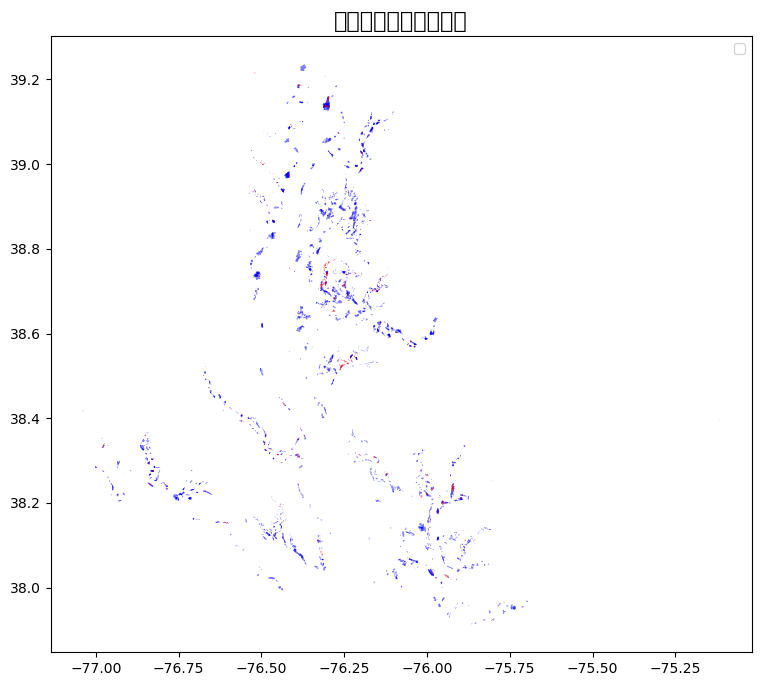

In [69]:
import matplotlib.pyplot as plt

# 筛选 2010 年前和 2010 年及之后的数据
before_2010 = restoration_areas[restoration_areas['time_period'] == 'Before 2010']
after_2010 = restoration_areas[restoration_areas['time_period'] == '2010 and After']

# 绘制地图
fig, ax = plt.subplots(figsize=(12, 8))
before_2010.plot(ax=ax, color='blue', alpha=0.5, label='Before 2010')
after_2010.plot(ax=ax, color='red', alpha=0.5, label='2010 and After')

# 设置标题和图例
plt.title('修复区域空间分布变化', fontsize=16)
plt.legend()
plt.show()


/Users/lijinpeng/anaconda3/envs/geo/lib/python3.12/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/lijinpeng/anaconda3/envs/geo/lib/python3.12/site-packages/geopandas/geodataframe.py:2675: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  return geopandas.overlay(
/var/folders/sd/bq10trhj0z7_p4t5bg48p4780000gn/T/ipykernel_59171/1070439988.py:12: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
/var/folders/sd/bq10trhj0z7_p4t5bg48p4780000gn/T/ipykernel_59171/1070439988.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when leg

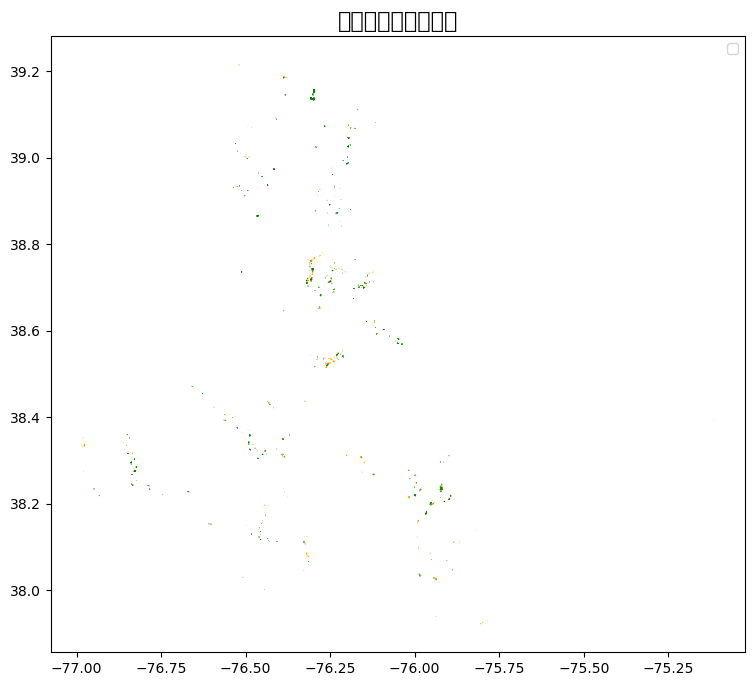

In [55]:
# 重叠区域
overlap = before_2010.overlay(after_2010, how='intersection')

# 2010 年新增区域（在 2010 年前不存在）
new_areas = after_2010.overlay(before_2010, how='difference')

# 绘制地图显示新增区域和重叠区域
fig, ax = plt.subplots(figsize=(12, 8))
overlap.plot(ax=ax, color='green', label='Overlap (Both Periods)')
new_areas.plot(ax=ax, color='orange', label='New Areas (After 2010)')
plt.title('空间重叠与新增区域', fontsize=16)
plt.legend()
plt.show()


## 评估这些新增区域是否位于新的栖息地或是历史低密度区域

In [58]:
# GeoDataFrame 使用的是地理坐标系（Geographic CRS，例如 EPSG:4326），而不是投影坐标系（Projected CRS，例如 EPSG:3857）。几何面积计算在地理坐标系下是不准确的，因为地理坐标系以经纬度表示，不适合直接进行面积测量。


EPSG:4326
EPSG:4326


In [61]:
# 转换为 UTM 投影 (EPSG:26918)
new_areas = new_areas.to_crs(epsg=26918)
historical_beds = historical_beds.to_crs(epsg=26918)

# 检查 CRS 是否已成功转换
print(new_areas.crs)
print(historical_beds.crs)


EPSG:26918
EPSG:26918


In [62]:
# 计算新增修复区域的总面积
new_areas['total_area'] = new_areas.geometry.area

# 计算新增修复区域与历史牡蛎床的重叠区域
overlap_with_history = new_areas.overlay(historical_beds, how='intersection')
overlap_with_history['overlap_area'] = overlap_with_history.geometry.area


In [63]:
# 计算重叠比例
overlap_ratio = overlap_with_history['overlap_area'].sum() / new_areas['total_area'].sum()
print(f"新增修复区域与历史牡蛎床的重叠比例: {overlap_ratio:.2%}")


新增修复区域与历史牡蛎床的重叠比例: 72.76%


## 生蚝面积减小了多少？

In [73]:
# 确保投影为 EPSG:26918，用于面积计算
restoration_areas = restoration_areas.to_crs(epsg=26918)
historical_beds = historical_beds.to_crs(epsg=26918)

# 筛选 2010 年之前和 2022 年及之前的数据
restoration_before_2010 = restoration_areas[restoration_areas['ActivityYr'] <= 2010]
restoration_before_2022 = restoration_areas[restoration_areas['ActivityYr'] <= 2022]

# 计算每个时间段的修复区域总面积
area_before_2010 = restoration_before_2010.geometry.area.sum()
area_before_2022 = restoration_before_2022.geometry.area.sum()

# 计算历史牡蛎床总面积
historical_area = historical_beds.geometry.area.sum()

# 计算面积减少比例
reduction_2010 = (historical_area - area_before_2010) / historical_area * 100
reduction_2022 = (historical_area - area_before_2022) / historical_area * 100

# 打印结果
print(f"历史牡蛎床总面积: {historical_area:.2f} 平方米")
print(f"2010 年之前修复区域面积: {area_before_2010:.2f} 平方米，减少比例: {reduction_2010:.2f}%")
print(f"2022 年及之前修复区域面积: {area_before_2022:.2f} 平方米，减少比例: {reduction_2022:.2f}%")


历史牡蛎床总面积: 871494220.95 平方米
2010 年之前修复区域面积: 370987771.31 平方米，减少比例: 57.43%
2022 年及之前修复区域面积: 400778797.10 平方米，减少比例: 54.01%


## 保护区的面积

In [76]:
print(sanctuaries_areas.info())

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   OBJECTID      59 non-null     int32   
 1   CLOSNAME      59 non-null     object  
 2   CLOSTYPE      59 non-null     object  
 3   TRIBNAME      59 non-null     object  
 4   REF           59 non-null     object  
 5   ACRES         59 non-null     float64 
 6   COMMENTS      59 non-null     object  
 7   Shape_Length  59 non-null     float64 
 8   Shape_Area    59 non-null     float64 
 9   geometry      59 non-null     geometry
dtypes: float64(3), geometry(1), int32(1), object(5)
memory usage: 4.5+ KB
None


In [77]:
# 确保数据集使用投影坐标系（如 EPSG:26918）
sanctuaries_areas = sanctuaries_areas.to_crs(epsg=26918)

# 按 CLOSTYPE 分组计算每类的总面积
sanctuary_areas = sanctuaries_areas.groupby('CLOSTYPE')['geometry'].apply(
    lambda x: x.area.sum()
).reset_index()

# 重命名列
sanctuary_areas.columns = ['CLOSTYPE', 'Total_Area']

# 打印结果
print(sanctuary_areas)


                  CLOSTYPE    Total_Area
0  PRE-SEPT 2010 SANCTUARY  1.799748e+08
1      SEPT 2010 SANCTUARY  8.442442e+08


In [78]:
import pandas as pd

# 设置 Pandas 显示格式，禁用科学计数法
pd.options.display.float_format = '{:,.2f}'.format

# 再次查看数据
print(sanctuary_areas)



                  CLOSTYPE     Total_Area
0  PRE-SEPT 2010 SANCTUARY 179,974,809.72
1      SEPT 2010 SANCTUARY 844,244,198.13
